In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [11]:
def load_data():
    breast_cancer_wisconsin_original = fetch_ucirepo(id=15)
    X = breast_cancer_wisconsin_original.data.features
    y = breast_cancer_wisconsin_original.data.targets

    # Combine features and targets
    df = pd.concat([X, y], axis=1)
    # check null values
    df.isna().sum()
    ## By analysing the dataset we get to know that df['Mitoses'] has outliers
    df.drop_duplicates(inplace=True)

    # Handle missing values
    if 'Bare_nuclei' in df.columns:
        df['Bare_nuclei'] = df['Bare_nuclei'].replace('?', np.nan).astype(float)
        df['Bare_nuclei'] = df['Bare_nuclei'].fillna(df['Bare_nuclei'].mean())

    # Fix the Mitoses column properly - avoid converting to boolean
    # Handle outliers using IQR method but keep numeric values
    Q1 = np.percentile(df['Mitoses'], 25)
    Q3 = np.percentile(df['Mitoses'], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    # Cap outliers instead of converting to boolean
    df['Mitoses'] = np.clip(df['Mitoses'], lower_bound, upper_bound)

    # Separate features and target
    X = df.iloc[:, :-1]
    y = df['Class']

    # Scale features
    mm = MinMaxScaler()
    X_scaled = pd.DataFrame(mm.fit_transform(X), columns=X.columns)

    return X_scaled, y, df

In [12]:
def exploratory_data_analysis(df):
    """Perform EDA on the dataset"""
    # Class distribution
    class_counts = df['Class'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts, labels=['Class ' + str(i) for i in class_counts.index],
            autopct='%1.2f%%', colors=['red', 'blue'])
    plt.title('Distribution of Classes')
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
    plt.title('Feature Correlation Heatmap')
    plt.show()

    # Boxplot of features
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df.iloc[:, :-1])
    plt.title('Feature Distributions')
    plt.xticks(rotation=45)
    plt.show()

In [13]:
def optimize_hierarchical_clustering(X, y):
    """Find optimal parameters for hierarchical clustering"""
    print("Optimizing Hierarchical Clustering parameters...")

    # Parameters to tune
    linkage_methods = ['ward', 'complete', 'average', 'single']
    distance_thresholds = [None, 0.5, 1.0, 1.5, 2.0]

    best_score = -1
    best_params = {}

    results = []

    # Try different combinations
    for linkage_method in linkage_methods:
        for n_clusters in range(2, 5):
            print(f"  Testing linkage={linkage_method}, n_clusters={n_clusters}")

            # Create model
            hc = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage_method
            )

            # Fit and predict
            cluster_labels = hc.fit_predict(X)

            # Map clusters to actual classes (0->2, 1->4)
            # Determine which cluster corresponds to which class
            cluster_to_class = {}
            for cluster in np.unique(cluster_labels):
                cluster_data = y[cluster_labels == cluster]
                most_common_class = cluster_data.mode()[0]
                cluster_to_class[cluster] = most_common_class

            # Map predictions to actual class labels
            mapped_predictions = np.array([cluster_to_class[cluster] for cluster in cluster_labels])

            # Calculate metrics
            accuracy = accuracy_score(y, mapped_predictions)
            silhouette = silhouette_score(X, cluster_labels)
            calinski = calinski_harabasz_score(X, cluster_labels)

            results.append({
                'linkage': linkage_method,
                'n_clusters': n_clusters,
                'accuracy': accuracy,
                'silhouette': silhouette,
                'calinski_harabasz': calinski
            })

            # Update best parameters if better accuracy found
            if accuracy > best_score:
                best_score = accuracy
                best_params = {
                    'linkage': linkage_method,
                    'n_clusters': n_clusters
                }

    results_df = pd.DataFrame(results)
    print("\nHierarchical Clustering Parameter Search Results:")
    print(results_df.sort_values('accuracy', ascending=False).head())

    print(f"\nBest Hierarchical Clustering Parameters: {best_params}")
    print(f"Best Accuracy: {best_score:.4f}")

    # Create best model
    best_hc = AgglomerativeClustering(
        n_clusters=best_params['n_clusters'],
        linkage=best_params['linkage']
    )

    return best_hc, best_params, best_score

In [14]:
def optimize_gmm(X, y):

    print("Optimizing Gaussian Mixture Model parameters...")

    # Parameters to tune
    n_components_range = range(2, 5)
    covariance_types = ['full', 'tied', 'diag', 'spherical']

    best_score = -1
    best_params = {}

    results = []

    # Try different combinations
    for n_components in n_components_range:
        for covariance_type in covariance_types:
            print(f"  Testing n_components={n_components}, covariance_type={covariance_type}")

            # Create model
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type=covariance_type,
                random_state=42,
                max_iter=200,
                n_init=10
            )

            # Fit and predict
            gmm.fit(X)
            cluster_labels = gmm.predict(X)

            # Map clusters to actual classes (0->2, 1->4)
            # Determine which cluster corresponds to which class
            cluster_to_class = {}
            for cluster in range(n_components):
                cluster_data = y[cluster_labels == cluster]
                if len(cluster_data) > 0:
                    most_common_class = cluster_data.mode()[0]
                    cluster_to_class[cluster] = most_common_class
                else:
                    # Handle empty clusters
                    cluster_to_class[cluster] = 2  # Default to benign

            # Map predictions to actual class labels
            mapped_predictions = np.array([cluster_to_class[cluster] for cluster in cluster_labels])

            # Calculate metrics
            accuracy = accuracy_score(y, mapped_predictions)

            # Only calculate silhouette score if we have at least 2 clusters with data
            if len(np.unique(cluster_labels)) > 1:
                silhouette = silhouette_score(X, cluster_labels)
                calinski = calinski_harabasz_score(X, cluster_labels)
            else:
                silhouette = 0
                calinski = 0

            results.append({
                'n_components': n_components,
                'covariance_type': covariance_type,
                'accuracy': accuracy,
                'silhouette': silhouette,
                'calinski_harabasz': calinski
            })

            # Update best parameters if better accuracy found
            if accuracy > best_score:
                best_score = accuracy
                best_params = {
                    'n_components': n_components,
                    'covariance_type': covariance_type
                }

    results_df = pd.DataFrame(results)
    print("\nGMM Parameter Search Results:")
    print(results_df.sort_values('accuracy', ascending=False).head())

    print(f"\nBest GMM Parameters: {best_params}")
    print(f"Best Accuracy: {best_score:.4f}")

    # Create best model
    best_gmm = GaussianMixture(
        n_components=best_params['n_components'],
        covariance_type=best_params['covariance_type'],
        random_state=42,
        max_iter=200,
        n_init=10
    )

    return best_gmm, best_params, best_score

In [15]:
def optimize_random_forest(X, y):

    print("Optimizing RandomForest for feature importance analysis...")

    # Set up parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    # Fit grid search
    grid_search.fit(X, y)

    print(f"Best RF Parameters: {grid_search.best_params_}")
    print(f"Best RF Accuracy: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def visualize_clusters(X, cluster_labels, true_labels, method_name):
    """Visualizes clustering results using PCA for dimensionality reduction"""
    # Apply PCA to reduce to 2 dimensions for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot the clusters
    plt.figure(figsize=(12, 10))

    # Plot the first subplot: clusters
    plt.subplot(2, 1, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
    plt.title(f'{method_name} Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')

    # Plot the second subplot: true labels
    plt.subplot(2, 1, 2)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='coolwarm', alpha=0.6)
    plt.title('True Class Labels (2=Benign, 4=Malignant)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Class')

    plt.tight_layout()
    plt.show()


In [16]:
def build_recommendation_system(X, cluster_labels, true_labels, feature_names, best_rf):
    """Builds an improved recommendation system based on clustering results"""
    # Map clusters to diagnostic labels
    # Determine which cluster corresponds to which class
    cluster_to_diagnosis = {}
    for cluster in np.unique(cluster_labels):
        cluster_data = true_labels[cluster_labels == cluster]
        percent_malignant = np.mean(cluster_data == 4)
        if percent_malignant > 0.5:
            cluster_to_diagnosis[cluster] = "Malignant"
        else:
            cluster_to_diagnosis[cluster] = "Benign"

    print("\nCluster to Diagnosis Mapping:")
    for cluster, diagnosis in cluster_to_diagnosis.items():
        percent = np.mean(true_labels[cluster_labels == cluster] == (4 if diagnosis == "Malignant" else 2)) * 100
        print(f"Cluster {cluster} → {diagnosis} ({percent:.1f}% confidence)")

    # Calculate feature means for each cluster
    cluster_feature_means = {}
    for cluster in np.unique(cluster_labels):
        cluster_data = X[cluster_labels == cluster]
        cluster_feature_means[cluster] = np.mean(cluster_data, axis=0)

    # Identify discriminative features with feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance for Diagnosis:")
    print(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance for Diagnosis')
    plt.tight_layout()
    plt.show()

    # Create cluster profiles with radar chart
    top_features = feature_importance['Feature'].head(5).tolist()

    # Radar chart for cluster profiles
    fig = plt.figure(figsize=(12, 8))
    radar = fig.add_subplot(111, polar=True)

    angles = np.linspace(0, 2*np.pi, len(top_features), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    for cluster in np.unique(cluster_labels):
        values = [cluster_feature_means[cluster][feature_names.tolist().index(feat)] for feat in top_features]
        values += values[:1]  # Close the loop

        label = f"Cluster {cluster} ({cluster_to_diagnosis[cluster]})"
        radar.plot(angles, values, linewidth=2, label=label)
        radar.fill(angles, values, alpha=0.25)

    radar.set_xticks(angles[:-1])
    radar.set_xticklabels(top_features)
    plt.legend(loc='upper right')
    plt.title('Cluster Profiles Based on Top Features')
    plt.show()

    # Recommendations based on clusters
    print("\nDiagnostic Recommendations:")
    for cluster in np.unique(cluster_labels):
        diagnosis = cluster_to_diagnosis[cluster]
        print(f"\nFor {diagnosis} cases (Cluster {cluster}):")

        # Get top features for this cluster
        cluster_values = {}
        for i, feature in enumerate(feature_names):
            cluster_values[feature] = cluster_feature_means[cluster][i]

        cluster_feature_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean Value': [cluster_values[f] for f in feature_names],
            'Importance': [feature_importance[feature_importance['Feature'] == f]['Importance'].values[0]
                          if f in feature_importance['Feature'].values else 0
                          for f in feature_names]
        }).sort_values('Importance', ascending=False)

        top_cluster_features = cluster_feature_df.head(3)['Feature'].tolist()

        if diagnosis == "Malignant":
            print(f"  - Critical indicators: {', '.join(top_cluster_features)}")
            print("  - Recommended actions:")
            print("    * Immediate medical consultation")
            print("    * Consider biopsy confirmation")
            print("    * Further imaging studies")
            print("    * Consider checking for specific characteristic patterns:")

            # Specific recommendations based on top features
            for feature in top_cluster_features:
                value = cluster_values[feature]
                if feature == "Uniformity_of_Cell_Size" and value > 0.7:
                    print(f"      - High {feature} ({value:.2f}): Suggests significant cell abnormality")
                elif feature == "Bare_nuclei" and value > 0.6:
                    print(f"      - Elevated {feature} ({value:.2f}): Often associated with aggressive tumors")
                elif feature == "Mitoses" and value > 0.3:
                    print(f"      - Increased {feature} ({value:.2f}): Indicates high cell division rate")
                else:
                    print(f"      - {feature} ({value:.2f}): Elevated from normal range")

        else:
            print("  - Recommended actions:")
            print("    * Regular follow-up screenings")
            print("    * Monitor for changes in cell characteristics")
            print("    * Routine preventive care")
            print("    * Key metrics to monitor:")

            # Specific recommendations based on top features
            for feature in top_cluster_features:
                value = cluster_values[feature]
                print(f"      - {feature} ({value:.2f}): Currently within normal range")

In [17]:
def main():
    # Load and prepare data
    X, y, df = load_data()

    # EDA
    print("\n--- Exploratory Data Analysis ---")
    exploratory_data_analysis(df)

    # Optimize hierarchical clustering
    print("\n--- Optimizing Hierarchical Clustering ---")
    best_hc, hc_params, hc_score = optimize_hierarchical_clustering(X, y)

    # Optimize GMM
    print("\n--- Optimizing Gaussian Mixture Model ---")
    best_gmm, gmm_params, gmm_score = optimize_gmm(X, y)

    # Apply the best models
    print("\n--- Applying Best Models ---")

    # Hierarchical clustering
    hc_labels = best_hc.fit_predict(X)

    # GMM
    best_gmm.fit(X)
    gmm_labels = best_gmm.predict(X)

    # Compare models
    print("\n--- Model Comparison ---")
    print(f"Hierarchical Clustering accuracy: {hc_score:.4f}")
    print(f"Gaussian Mixture Model accuracy: {gmm_score:.4f}")

    # Visualize best clustering results
    if hc_score > gmm_score:
        print("\nHierarchical Clustering performed better")
        best_labels = hc_labels
        method = "Hierarchical Clustering"
    else:
        print("\nGaussian Mixture Model performed better")
        best_labels = gmm_labels
        method = "Gaussian Mixture Model"

    visualize_clusters(X.values, best_labels, y.values, method)

    # Optimize Random Forest for feature importance
    best_rf = optimize_random_forest(X, best_labels)

    # Build recommendation system
    print(f"\n--- Building Improved Recommendation System based on {method} ---")
    build_recommendation_system(X.values, best_labels, y.values, X.columns, best_rf)

    print("\nBreast Cancer Diagnostic System analysis complete.")


--- Exploratory Data Analysis ---


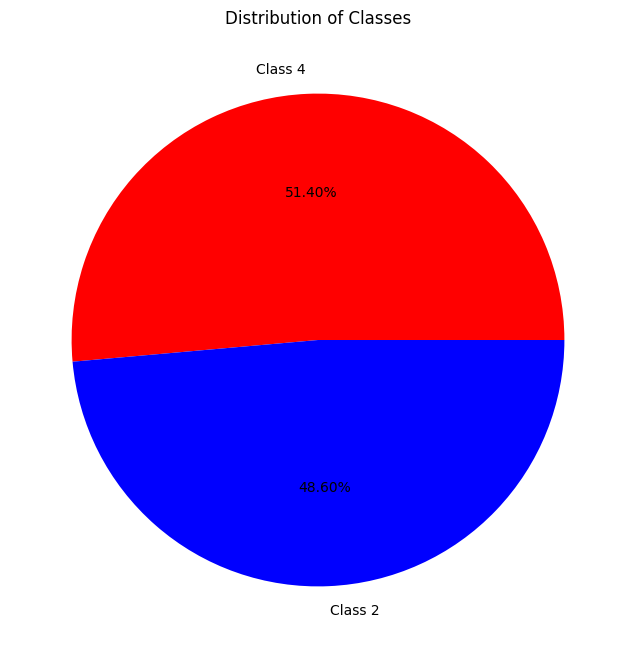

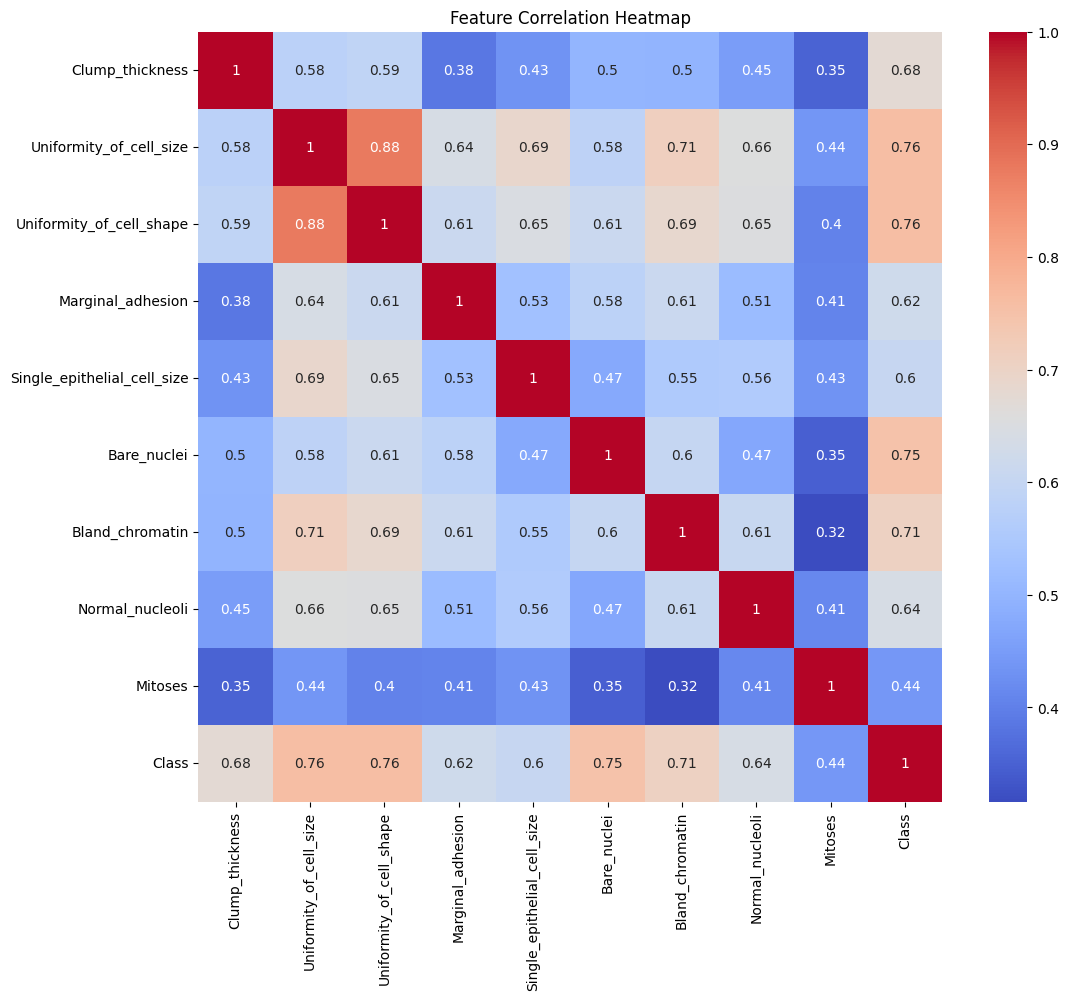

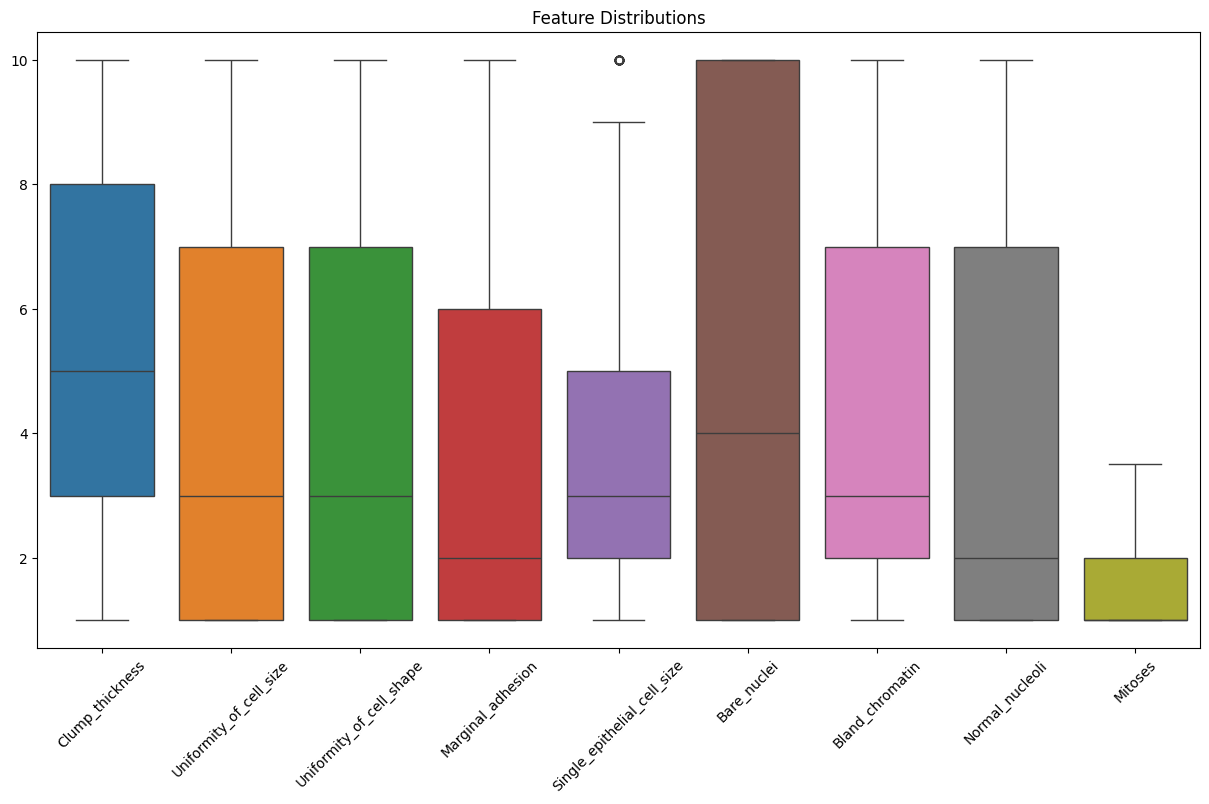


--- Optimizing Hierarchical Clustering ---
Optimizing Hierarchical Clustering parameters...
  Testing linkage=ward, n_clusters=2
  Testing linkage=ward, n_clusters=3
  Testing linkage=ward, n_clusters=4
  Testing linkage=complete, n_clusters=2
  Testing linkage=complete, n_clusters=3
  Testing linkage=complete, n_clusters=4
  Testing linkage=average, n_clusters=2
  Testing linkage=average, n_clusters=3
  Testing linkage=average, n_clusters=4
  Testing linkage=single, n_clusters=2
  Testing linkage=single, n_clusters=3
  Testing linkage=single, n_clusters=4

Hierarchical Clustering Parameter Search Results:
   linkage  n_clusters  accuracy  silhouette  calinski_harabasz
8  average           4  0.937365    0.354749         220.056930
0     ward           2  0.913607    0.442235         430.204968
1     ward           3  0.913607    0.393371         295.404677
2     ward           4  0.913607    0.351838         229.395845
6  average           2  0.911447    0.434649         414.117710



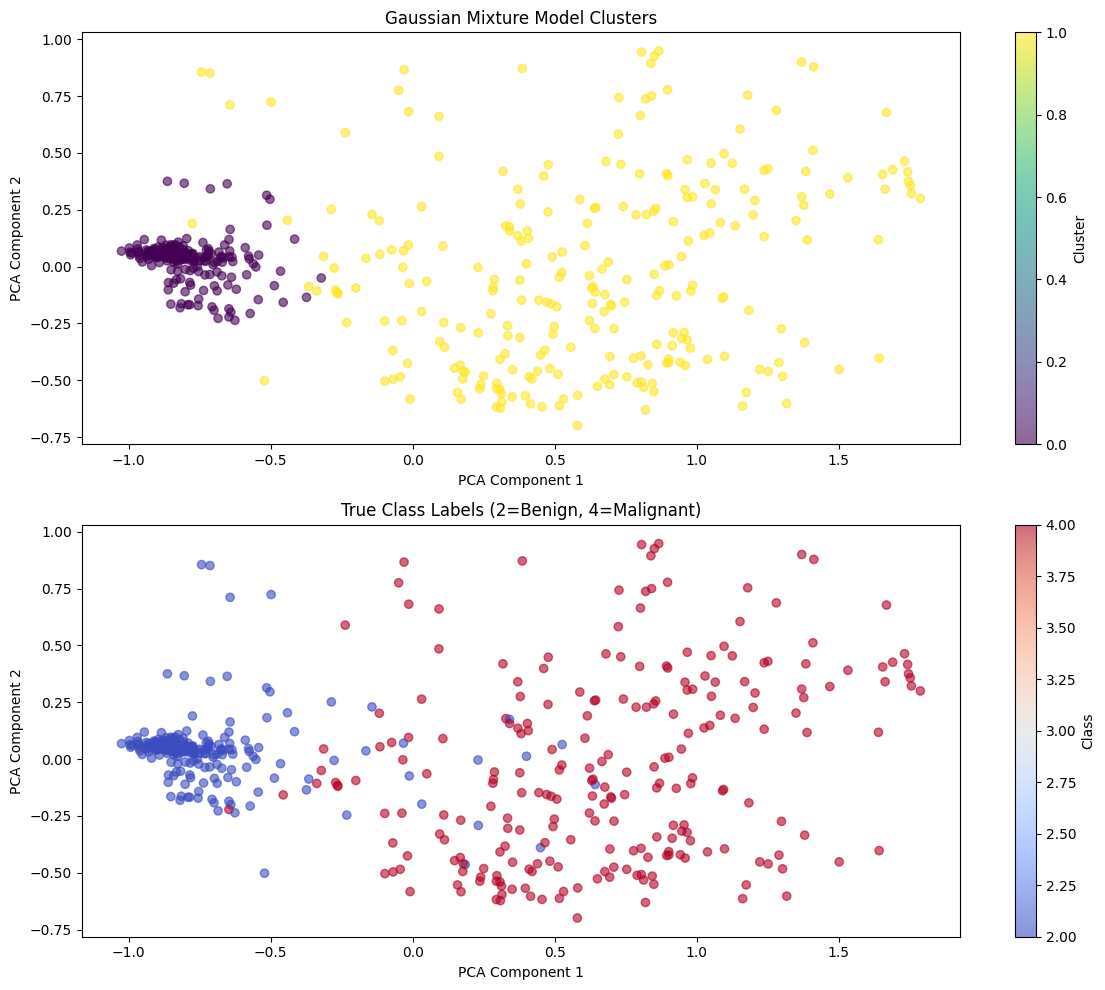

Optimizing RandomForest for feature importance analysis...
Best RF Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best RF Accuracy: 0.9784

--- Building Improved Recommendation System based on Gaussian Mixture Model ---

Cluster to Diagnosis Mapping:
Cluster 0 → Benign (98.5% confidence)
Cluster 1 → Malignant (90.7% confidence)

Feature Importance for Diagnosis:
                       Feature  Importance
1      Uniformity_of_cell_size    0.309058
2     Uniformity_of_cell_shape    0.230308
4  Single_epithelial_cell_size    0.113620
7              Normal_nucleoli    0.100483
5                  Bare_nuclei    0.084385
6              Bland_chromatin    0.077297
8                      Mitoses    0.043104
0              Clump_thickness    0.025024
3            Marginal_adhesion    0.016720


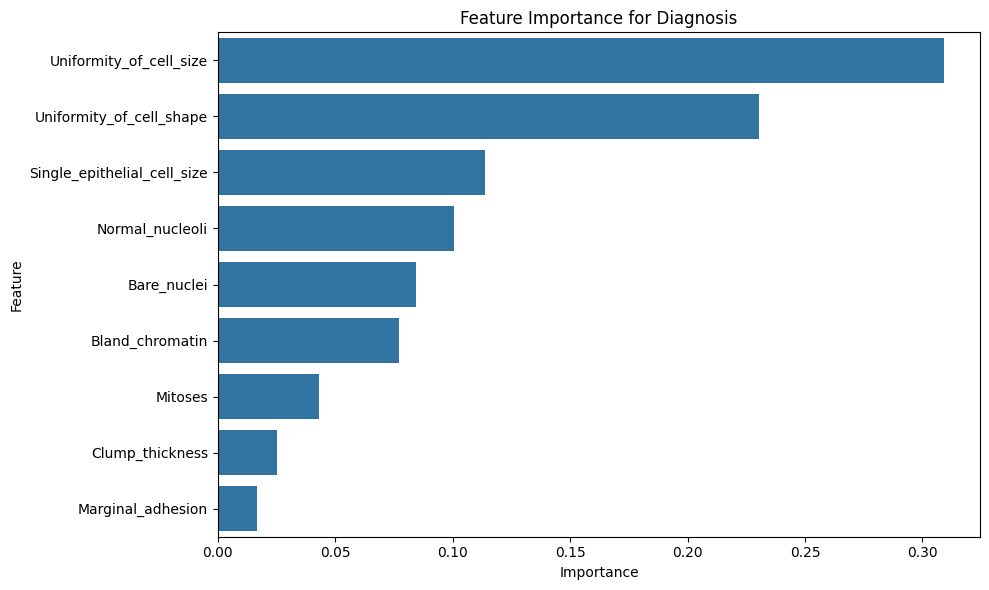

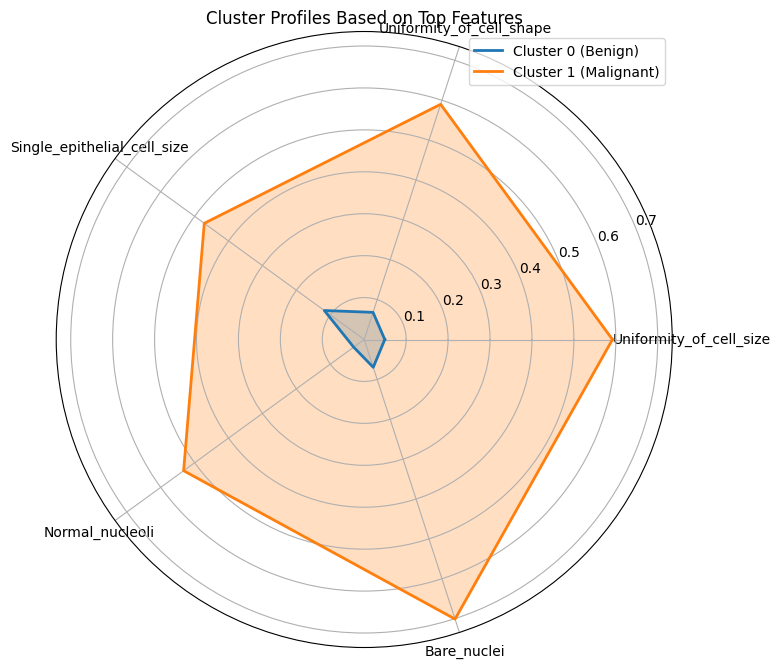


Diagnostic Recommendations:

For Benign cases (Cluster 0):
  - Recommended actions:
    * Regular follow-up screenings
    * Monitor for changes in cell characteristics
    * Routine preventive care
    * Key metrics to monitor:
      - Uniformity_of_cell_size (0.05): Currently within normal range
      - Uniformity_of_cell_shape (0.07): Currently within normal range
      - Single_epithelial_cell_size (0.12): Currently within normal range

For Malignant cases (Cluster 1):
  - Critical indicators: Uniformity_of_cell_size, Uniformity_of_cell_shape, Single_epithelial_cell_size
  - Recommended actions:
    * Immediate medical consultation
    * Consider biopsy confirmation
    * Further imaging studies
    * Consider checking for specific characteristic patterns:
      - Uniformity_of_cell_size (0.59): Elevated from normal range
      - Uniformity_of_cell_shape (0.59): Elevated from normal range
      - Single_epithelial_cell_size (0.47): Elevated from normal range

Breast Cancer Diagnos

In [18]:
if __name__ == "__main__":
    main()